In [33]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="mNtCGUoodj9VqpV25W82")
project = rf.workspace("alexander-seleznev-6rssc").project("x-ray-classification")
version = project.version(1)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...


In [34]:
!pip install torch torchvision torchaudio
!pip install matplotlib scikit-learn pandas

In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
from PIL import Image
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


In [36]:
from roboflow import Roboflow
rf = Roboflow(api_key="mNtCGUoodj9VqpV25W82")
project = rf.workspace("alexander-seleznev-6rssc").project("x-ray-classification")
version = project.version(1)
dataset = version.download("folder")
dataset_path = dataset.location

loading Roboflow workspace...
loading Roboflow project...


In [37]:
data_dir = '/content/X-Ray-classification-1'  # Change if your folder is elsewhere

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# 4. Data Transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [38]:
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [39]:
class_names = train_dataset.classes  # ['NORMAL', 'PNEUMONIA']
print("Classes:", class_names)

Classes: ['NORMAL', 'PNEUMONIA']


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(pretrained=True)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.


In [41]:
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 1)
model = model.to(device)

In [42]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [43]:
def train_model(model, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}")

train_model(model, criterion, optimizer, epochs=5)

Epoch 1/5 - Loss: 0.1664
Epoch 2/5 - Loss: 0.0742
Epoch 3/5 - Loss: 0.0472
Epoch 4/5 - Loss: 0.0276
Epoch 5/5 - Loss: 0.0241


In [44]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs).cpu().numpy() > 0.5

        all_preds.extend(preds.flatten())
        all_labels.extend(labels.numpy())


In [45]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.96      0.96       311
   PNEUMONIA       0.99      0.99      0.99       855

    accuracy                           0.98      1166
   macro avg       0.97      0.98      0.97      1166
weighted avg       0.98      0.98      0.98      1166

Confusion Matrix:
 [[300  11]
 [ 12 843]]


In [47]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')


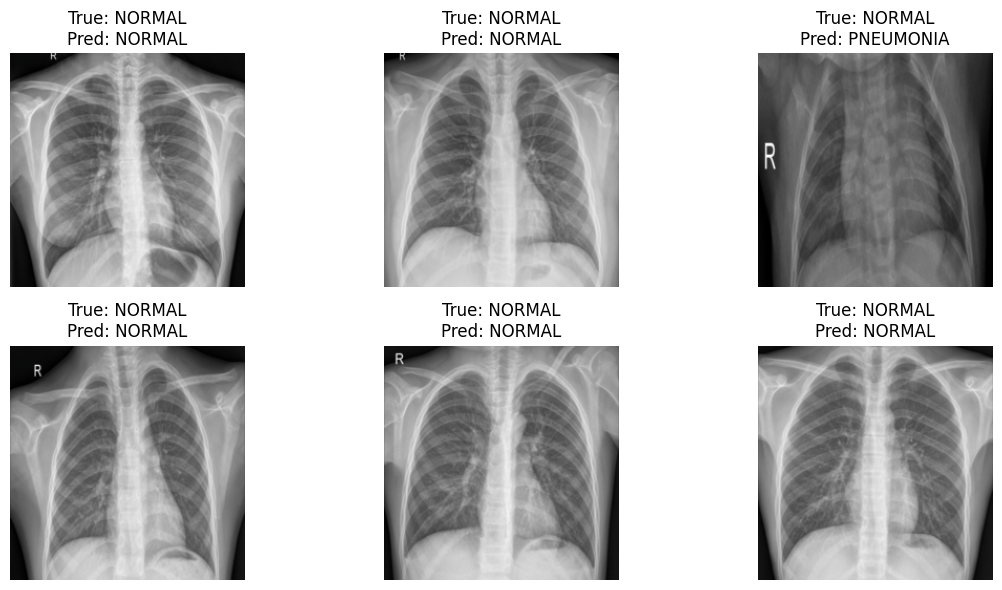

In [48]:
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
outputs = model(inputs)
preds = (torch.sigmoid(outputs) > 0.5).int().cpu().flatten()

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow(inputs[i].cpu())
    true_label = class_names[labels[i]]
    predicted_label = class_names[preds[i]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
plt.tight_layout()
plt.show()